**<h1 style="text-align: center;">Badanie efektywności algorytmu unikania kolizji w przestrzeni powietrznej</h1>**

**<h3 style="text-align: center;">Jakub Wolniak</h3>**

**<h3 style="text-align: center;">151797</h3>**

## Cel eksperymentu:

Zbadać efektywność algorytmu solwera CPLEX wykorzystywanego do rozwiązywania problemu programowania matematycznego sformułowanego na Laboratorium 2/4. Efektywność algorytmu rozumiana jest jako zależność czasu obliczeń od rozmiaru i/lub stopnia skomplikowania rozwiązywanej instancji problemu.

## Użyty algorytm

### Biblioteki

In [1]:
import random
import numpy as np
from docplex.mp.model import Model
import time

### Funkcja generująca losowe instancje testowe

Funkcja przyjmuje parametry: \
n - liczba samolotów \
m - liczba dostępnych manewrów \
w - miara „zachowania konfliktu” \
p - prawdopodobieństwo wystąpienia konfliktu między dwoma samolotami poruszającymi się po pierwotnie ustalonych trasach \
\
Funkcja zwraca macierz konfliktów, w której wartość 1 oznacza konflikt, a 0 jego brak.

In [2]:
def generate_conflict_matrix(n, m, w, p):
    pm = p * 2**((1-m)/w)
    rows = n * m
    conflicts_num = int(((rows - 1) * rows * pm) / 2)
    
    matrix = np.zeros((rows, rows), dtype=int)
    indices = random.sample(range(rows * (rows - 1) // 2), conflicts_num)
    indices_set = set(indices)
    k = 0
    for i in range(rows - 1):
        for j in range(i + 1, rows):
            if k in indices_set:
                matrix[i, j] = 1
                matrix[j, i] = 1
            k += 1
    np.fill_diagonal(matrix, 1)
    return matrix

### Funkcje pomocnicze

Funkcja dzieląca wygenerowaną macierz na fragmenty

In [ ]:
def create_chunks(CM, n, m):
    chunks = []
    for i in range(0, n*m, m):
        for j in range(0, n*m, m):
            chunk = CM[i:i+m, j:j+m]
            chunks.append(chunk)
    return chunks

Funkcja tworzy obiekt Model z biblioteki docplex. \
Następnie tworzona jest macierz zmiennych binarnych o wymiarze n x m. \
Później funkcją minimize() definiowana jest funkcja celu do poszukiwania rozwiązania optymalnego.

In [ ]:
def create_model_opt(n, m):
    model = Model()
    model.name = 'Model_optymalny'
    x = model.binary_var_matrix(range(1, n + 1), range(1, m + 1), name=lambda ns: f'x_{ns[0]}_{ns[1]}')
    model.minimize(model.sum(j * x[i, j] for i in range(1, n + 1) for j in range(1, m + 1)))
    return model, x

Funkcja ustawiająca model do poszukiwania rozwiązania dopuszczalnego. Rózni się funkcją celu od modelu optymalnego.

In [ ]:
def create_model_fea(n, m):
    model = Model()
    model.name = 'Model_dopuszczalny'
    x = model.binary_var_matrix(range(1, n + 1), range(1, m + 1), name=lambda ns: f'x_{ns[0]}_{ns[1]}')
    model.minimize(1)
    return model, x

Funkcja dodająca ograniczenia do modelu

In [ ]:
def add_constraints(model, n, m, x, chunks):
    for i in range(1, n + 1):
        model.add_constraint(model.sum(x[i, j] for j in range(1, m + 1)) == 1)

    for i in range(n):
        for j in range(m):
            for k in range(i + 1, n):
                if i != k:
                    for l in range(m):
                        chunk = chunks[i*n+k]
                        if chunk[j][l] == 1:
                            model.add_constraint(x[i+1, j+1]+x[k+1, l+1] <= 1)

Funkcja rozwiązująca model i mierząca czas rozwiązania

In [3]:
def solve_model(model):
    start_time = time.time()
    model.solve()
    stop_time = time.time()
    return stop_time - start_time

## Funkcja zbierająca dane
Funkcja iteruje po parametrach tworząc każdą ich kombinację. Dla każdej z kombinacji generowane jest 10 instancji testowych. Dla każdej instancji tworzone są dwa modele, jeden który poszukuje rozwiązania dopuszczalnego i drugi, który poszukuje rozwiązania optymalnego. Dla każdego rozwiązania mierzony jest czas.

In [5]:
def analyze_parameters():
    n_values = [10, 20, 30, 40]
    m_values = [3, 5, 7, 9]
    p_values = [0.6, 0.8, 1]
    w_values = [1, 5, 10]
    results = []

    for n in n_values:
        print(f'n = {n}')
        for m in m_values:
            print(f'm = {m}')
            for p in p_values:
                print(f'p = {p}')
                for w in w_values:
                    print(f'w = {w}')
                    for i in range(10): 
                        print(f'Iteracja {i}')
                        CM = generate_conflict_matrix(n, m, w, p)
                        chunks = create_chunks(CM, n, m)

                        start_time = time.time()
                        model, x = create_model_fea(n, m)
                        add_constraints(model, n, m, x, chunks)
                        solve_model(model)
                        execution_time_fea = time.time() - start_time
                        if model.solution is None:
                            solution_fea_exists = False
                        else:
                            solution_fea_exists = True
                        model.clear()

                        start_time = time.time()
                        model, x = create_model_opt(n, m)
                        add_constraints(model, n, m, x, chunks)
                        solve_model(model)
                        execution_time_opt = time.time() - start_time
                        if model.solution is None:
                            solution_opt_exists = False
                        else:
                            solution_opt_exists = True
                        model.clear()

                        results.append((n, m, p, w, execution_time_fea, solution_fea_exists, execution_time_opt, solution_opt_exists))

    return results

Funkcja main wywołuje powyższą funkcję oraz zapisuje jej wyniki do pliku tekstowego

In [ ]:
def main():
    results = analyze_parameters()
    with open('results3.txt', 'w') as file:
        for result in results:
            file.write(f'{result}\n')

Przykładowy wiersz z pliku z danymi:

(10, 3, 0.6, 1, 0.01686573028564453, True, 0.011523962020874023, True)

(n, m, p, w, czas pracy solvera - rozwiązanie dopuszczalne, czy rozwiązanie dopuszcalne istnieje,  czas pracy solvera - rozwiązanie optymalne, czy rozwiązanie optymalne istnieje)

Dane z pliku tekstowego są przedstawiane na wykresie przez osobny program parse'ujący.

## Parser

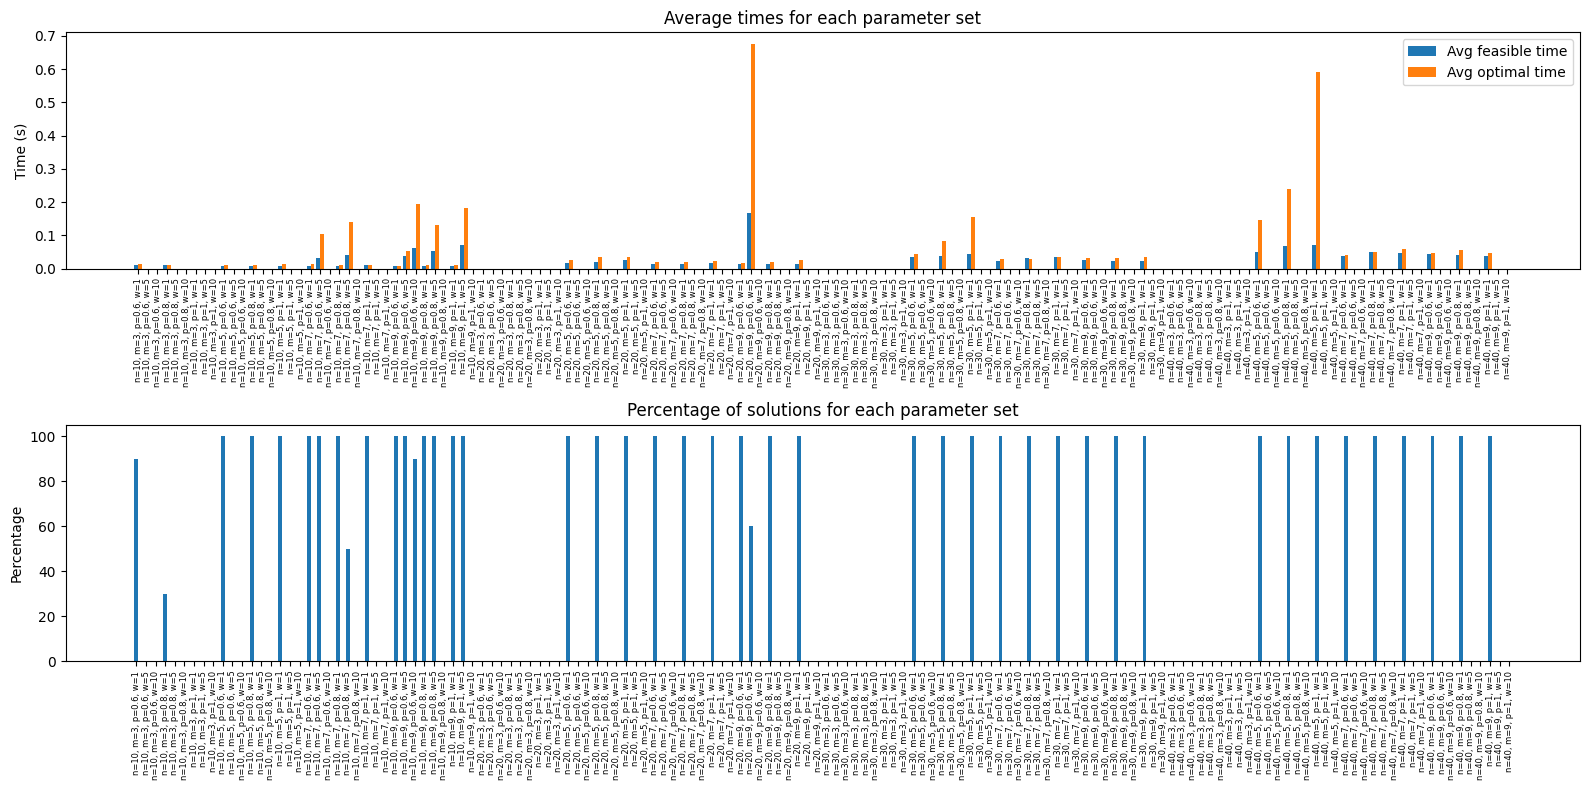

In [9]:
import matplotlib.pyplot as plt
import numpy as np

class Record:
    def __init__(self, n, m, p, w):
        self.n = n
        self.m = m
        self.p = p
        self.w = w
        self.total_5th = 0
        self.total_7th = 0
        self.count_5th = 0
        self.count_7th = 0
        self.count_true = 0
        self.count_total = 0

    def add_data(self, value_5th, value_6th, value_7th, value_8th):
        self.count_total += 1
        if value_6th:
            self.total_5th += value_5th
            self.count_5th += 1
        if value_8th:
            self.total_7th += value_7th
            self.count_7th += 1
        if value_6th or value_8th:
            self.count_true += 1

    def get_average_5th(self):
        return self.total_5th / self.count_5th if self.count_5th else 0

    def get_average_7th(self):
        return self.total_7th / self.count_7th if self.count_7th else 0

    def get_percentage_true(self):
        return self.count_true / self.count_total * 100

def parse_file(filename):
    records = {}
    with open(filename, 'r') as file:
        for row in file.readlines():
            row = row.split("()")
            n, m, p, w, value_5th, value_6th, value_7th, value_8th = eval(row[0])
            key = (n, m, p, w)
            if key not in records:
                records[key] = Record(n, m, p, w)
            records[key].add_data(value_5th, value_6th, value_7th, value_8th)
    return list(records.values())

def print_parsed(records):
    for record in records:
        print(f'n = {record.n}, m = {record.m}, p = {record.p}, w = {record.w}')
        print(f'Średni czas wykonania dla rozwiązania dopuszczalnego: {record.get_average_5th()} sekund')
        print(f'Średni czas wykonania dla rozwiązania optymalnego: {record.get_average_7th()} sekund')
        print(f'Procent poprawnych rozwiązań: {record.get_percentage_true()}%')
    
def main():
    records = parse_file('results3.txt')
    labels = [f'n={r.n}, m={r.m}, p={r.p}, w={r.w}' for r in records]
    avg_5th_times = [r.get_average_5th() for r in records]
    avg_7th_times = [r.get_average_7th() for r in records]
    percentages = [r.get_percentage_true() for r in records]

    x = np.arange(len(labels))  # the label locations

    fig, axs = plt.subplots(2, 1, figsize=(16, 8))

    # Plot for average times
    axs[0].bar(x - 0.2, avg_5th_times, 0.4, label='Avg feasible time')
    axs[0].bar(x + 0.2, avg_7th_times, 0.4, label='Avg optimal time')

    axs[0].set_ylabel('Time (s)')
    axs[0].set_title('Average times for each parameter set')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(labels, ha='center', rotation=90, fontsize=6)
    axs[0].legend()

    # Plot for percentage of solutions
    axs[1].bar(x, percentages, 0.4)

    axs[1].set_ylabel('Percentage')
    axs[1].set_title('Percentage of solutions for each parameter set')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels, ha='center', rotation=90, fontsize=6)

    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

Wykres górny obrazuje średni czas znajdowania rozwiązania optymalnego (pomarańczowy) i dopuszczalengo (niebieski). Wykres dolny pokazuje procent rozwiązanych instancji testowych dla każdego zestawu parametrów. \
Już na tym etapie widać, że parametr 'w' ma największy wpływ na znajdowanie rozwiązań. Rozwiązania są zazwyczaj znajdowane dla instancji z w = 1, lecz gdy parametr ten wzrośnie solver nie znajduje rozwiązań, szczególnie w przypadku większych wartości n.

# Analiza wyników

## Wpływ parametu n na czas obliczeń

Na poniższym wykresie widać, że czas działania solvera jest liniowy w prawie wszystkich przypadkach, poza poszukiwaniem rozwiązania optymalnego dla m = 5. W wykresach dla innych wartości parametu p trendy są takie same. (Rozważane są tylko wyniki dla parametu w = 1 ze względu na problem opisany wyżej.)

![alt text](wykres1.png "Title")

## Wpływ parametu m na znajdowanie rozwiązań

Na pierwszym wykresie na dolnej części widać, że w rejonie gdzie n = 10 wraz ze wzrostem parametu m rozwiązywane jest więcej instancji testowych.

## Wpływ parametru p na czas obliczeń

Wykres dla parametrów w = 1, m = 9. Z wykresu nie wynika, że parametr p ma rozpoznawalny wpływ na czasy obliczeń.

![alt text](wykres2.png "Title")

## Czy czasy obliczeń są najdłuższe dla instancji, w których prawdopodobieństwo konfliktu jest „średnie”?

Z górnej części pierwszego wykresu można wyciągnąć wniosek, że średnie prawdopodobieństwo konfliktu rzeczywiście jest czynnikiem wydłużającym obliczenia. Wynika to z wielu możliwych rozwiązań co utrudnia znalezienie rozwiązania optymalnego.